# Stream identification

This script takes habitat/object input with geometry (streams) and does classification (naturality assesment) to them. Classification is done with
Random Forest and Neural Networks. Creation of classification context (X) preceeds classification (prediction of Y).

Reference input is needed for supervised learning and classification context (variables) for assesment.

Parts of this notebook are not necessarily meant to always be run in presentation order. E.g. when the prediction is further developed, one can start from
"Still not good, consider following" where additional data and additional parameters are added to re run the "Apply machine learning methods..."

# Imports

In [2]:
from tensorflow import keras
import numpy as np
import geopandas as gpd
import pandas as pd
import dask_geopandas as dask_gpd
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from itertools import chain
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import os
from shapely.geometry import LineString, Point
from itertools import combinations
import rasterio as rs
from collections import Counter
import os
import cProfile
import time
from scipy.spatial import distance
from scipy.spatial import cKDTree
from shapely.geometry import LineString, Polygon



# Reading input, dissolving it by group and subsetting it into smaller sets for processing

-dataset is grouped by "kohdeluokka" which tells about the size of the stream (under 2m and 2-5m classes)  
-each group is dissolved separately, so that the lines are less fragmented  
-dask geopandas is used to partition the input data into npartitions = input. This is due to heavy processing cost and need to process in steps  

In [ ]:
filename = r"YourPath"
ddf = dask_gpd.read_file(filename, npartitions=1)
df = ddf.compute()
print(len(df))

#dissolve
groups = df.groupby('kohdeluokka')
for name, group in groups:
    print(name)
    # unary_union to combine all geometries into a MultiLineString
    multi_line = group.geometry.unary_union
    # linemerge to merge LineStrings that share a start or end point
    merged_lines = linemerge(multi_line)
    # Convert the merged lines back to a GeoDataFrame
    merged_gdf = gpd.GeoDataFrame(geometry=[merged_lines])
    # to singlepart
    singlepart_gdf = merged_gdf.explode(index_parts=False)
    singlepart_gdf = singlepart_gdf.set_crs(epsg=3067)
    singlepart_gdf.to_parquet(rf"Path\{name}.parquet")


filename = r"YourPath"
folder = r"YourPath"  


# Read the Parquet file into a Dask GeoDataFrame with 10 partitions
ddf = dask_gpd.read_parquet(filename, npartitions=10)
ddf = ddf.repartition(npartitions=10) #ensure that there are n amount of partitions

#if you want to name each partition as something spesific
name_function = lambda x: f"Virtavesi36311_part{x}.parquet"  
ddf.to_parquet(folder, name_function=name_function)

# Creation of classification context
Each input row is processed to include additional variables that could explain the class differences

-define input directory to loop through, usually the folder defined in the previous step, including the input in parts  
-define reference data with manually classified features. this is used to extract input features that intersect with reference input as reference data. enables data homogeneity, if reference data is in a different form  
-create a "counter system" that enables stopping the process midway. On the next run remembers the last processed part and continues from there. this requires that the user does not add extra files into output folder  
-calculates geometry-attributes of each input line: length, simplified length, ratio of these lengths, number of vertices, sinuosity, sum and mean distance to neighbor line centroids, max and mean distance in vertices  
-samples raster values in each vertex and calculates mean and median values for each line. DTW, slope, soil

beware
If a geometry from sample[COI] intersects with multiple geometries from Reference, then multiple rows will be added to the intersected DataFrame for that particular geometry from sample[COI]. Each of these rows will have the same data from sample[COI] but different matching data from Reference.
*COI is Columns Of Interest

So, if there are multiple intersections, the number of rows in the resulting DataFrame intersected can be greater than the number of rows in the original sample[COI] DataFrame. If there are no intersections for a particular row, the columns for Reference will be filled with NaN values. This is handled later in the "drop geometric duplicates" part.

In [3]:
start_time = time.time()

# Specify the directory where the Parquet files are
directory = r"YourPath"
ref_file = r"YourPath"
ddf = dask_gpd.read_parquet(ref_file, npartitions=1)
Reference =  ddf.compute()
# Specify the directory where the output files are
directory_out = r"YourPath"


# Initialize a counter
counter = 0
max_count = 12 #309 kuntaa
progressInterval = 10

num_files = len([f for f in os.listdir(directory_out) if os.path.isfile(os.path.join(directory_out, f)) and f.endswith('.parquet')])
lastCount = num_files #total number of (parquet) files in the folder
#lastCount = 9 #or this if you want to set end point manually
print("starting from", lastCount)

# Loop over each file in the directory
for filename in os.listdir(directory):
    # Check if the file is a Parquet file
    name_without_extension = os.path.splitext(filename)[0]

    # Increment the counter
    counter += 1      
    #print(counter,name_without_extension)


    # Skip if already processed
    if counter < lastCount+1:
        continue

    # Break the loop after processing x files
    if counter == max_count+1:
        break

    # Print the progression every x counts
    if counter % progressInterval == 0:
        print(f'Progression {counter}/{max_count}')        
        

    if filename.endswith('.parquet'):
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        
        # Read the Parquet file into a DataFrame
        ddf = dask_gpd.read_parquet(filepath, columns = ['geometry'], npartitions = 4)
        ddf['kohdekoodi'] = name_without_extension
        tolerance = 10
        ddf['geometry2'] = ddf['geometry'].map_partitions(lambda s: s.simplify(tolerance))
        sample = ddf.compute()
        #sample = sample.explode().reset_index(drop=True) #if multipart geometry error
        #sample['geometry2'] = sample['geometry'].map_partitions(lambda s: s.simplify(tolerance))

        #print out the file from which processing is resumed
        print(counter,name_without_extension, len(sample))

        # Process the DataFrame here
        sample['length'] = sample['geometry'].length
        sample['length_simplified'] = sample['geometry2'].length
        sample['length_ratio'] = sample['length']/sample['length_simplified']
        sample['num_vertices'] = sample['geometry'].apply(lambda x: len(x.coords))

        def calculate_distances(line):
            # Calculate all pairwise distances between vertices
            coords = np.array(line.coords)
            distances = distance.pdist(coords)
            # Find the maximum distance
            max_dist = max(distances)
            # Find the mean distance
            mean_dist = sum(distances) / len(distances)
            return max_dist, mean_dist
        # Apply the function to the geometry column
        sample['max_distance'], sample['mean_distance'] = zip(*sample['geometry'].apply(calculate_distances))

        def calculate_sinuosity(line):
            if len(line.boundary.geoms) == 2:  # Check if LineString has start and end points
                return line.length / line.boundary.geoms[0].distance(line.boundary.geoms[1])
            else:
                return None  # or some other value indicating an error
        sample['sinuosity'] = sample['geometry'].apply(calculate_sinuosity)

        print("distance matrix")
        # Centroid coordinates
        coords = np.array([(line.centroid.x, line.centroid.y) for line in sample['geometry']])
        # Create a cKDTree spatial index
        tree = cKDTree(coords)
        # Calculate the distance to the closest 20 LineStrings for each LineString
        k = 21
        distances, indices = tree.query(coords, k=k)  # k=wanted number+1 because the first one is the LineString itself
        # The first LineString in 'indices' and 'distances' is the LineString itself, so we exclude it
        closest_lines = indices[:, 1:]
        closest_distances = distances[:, 1:]
        # Calculate the sum of the distances to the x closest LineStrings
        sum_distances = closest_distances.sum(axis=1)
        # Add the 'sum_distances' to the GeoDataFrame as a new column
        sample['Neighbor_DistanceSum'] = sum_distances
        sample['Neighbor_DistanceMean'] = sample.Neighbor_DistanceSum/(k-1)

        sample['coords'] = sample['geometry'].apply(lambda x: list(x.coords))

        #Raster processig
        #sample raster values in each vertex
        #reuse the coords column for each raster
        print("starting raster value extraction")
        filename = r"YourRasterPath.tif"
        with rs.open(filename) as raster:
            sample['DTW1ha'] = sample['coords'].apply(lambda x: [val[0] for val in raster.sample(x)])
        sample['DTW1ha_mean'] = sample['DTW1ha'].apply(np.mean)
        sample['DTW1ha_median'] = sample['DTW1ha'].apply(np.median)

        print("slope raster")
        filename = r"YourRasterPath.tif"
        with rs.open(filename) as raster:
            sample['slope'] = sample['coords'].apply(lambda x: [val[0] for val in raster.sample(x)])
        sample['slope_mean'] = sample['slope'].apply(np.mean)
        sample['slope_median'] = sample['slope'].apply(np.median)

        print("soil raster")
        filename = r"YourRasterPath.tif"
        with rs.open(filename) as raster:
            sample['soil'] = sample['coords'].apply(lambda x: [val[0] for val in raster.sample(x)])

        # Function to apply to the 'soil' column. This raster included aggregated surface+base class that needed separation
        def split_soil(lst):
            soil_surface = []
            soil_base = []
            for num in lst:
                num_str = str(num)
                if len(num_str) == 2:
                    soil_surface.append(int(num_str))
                    soil_base.append(int(num_str))
                elif len(num_str) == 4:
                    soil_surface.append(int(num_str[:2]))
                    soil_base.append(int(num_str[2:]))
            # Find the most common value in the 'soil_surface' and 'soil_base' lists
            most_common_surface = Counter(soil_surface).most_common(1)[0][0] if soil_surface else None
            most_common_base = Counter(soil_base).most_common(1)[0][0] if soil_base else None
            return pd.Series([most_common_surface, most_common_base])

        # Apply the function and create new columns
        sample[['soil_surface', 'soil_base']] = sample['soil'].apply(split_soil)


        #reference
        print("extracting reference")
        COI  = ['length',
       'length_simplified', 'length_ratio', 'num_vertices', 'max_distance',
       'mean_distance', 'sinuosity', 'Neighbor_DistanceSum',
       'Neighbor_DistanceMean', 'DTW1ha', 'DTW1ha_mean', 'DTW1ha_median',
       'slope', 'slope_mean', 'slope_median', 'soil', 'soil_surface',
       'soil_base', 'kohdekoodi','geometry']
        #sample2 = sample[COI]
        # Perform the spatial join
        intersected = gpd.sjoin(sample[COI], Reference, how='left', predicate='intersects')
        intersected2 = intersected[intersected.index_right.notnull()]
        #intersected = intersected.drop(columns=['index_right'])


        print("saving")
        out_file = rf"YourPath\{name_without_extension}.parquet"

        intersected.to_parquet(out_file)
        #Reference saving
        ref_out = rf"YourPath\{name_without_extension}.parquet"

        intersected2.to_parquet(ref_out)
#print("saving to", out_file)
#print("saving to", ref_out)
print("elapsed time",time.time() - start_time)



starting from 2


  sample = sample.explode().reset_index(drop=True) #if multipart geometry


4 virtavesikapea2014_disjoint 3216431
distance matrix
starting raster value extraction
slope raster
soil raster
extracting reference
saving
elapsed time 7339.186942815781


# Append the data that was processed in parts into one file
For practical purposes and eg. when the data is normalized and global minmax values required. In some cases training within subsets can be beneficial (as criterium might differ in different subsets) and appending not suggested.

In [4]:
#OPTIONAL. to see partition sizes, no output instead of print statement
# Directory where your GeoParquet files are stored
directory = r"YourPath\\"

# Get a list of all GeoParquet files in the directory
files = [f for f in os.listdir(directory) if f.endswith('.parquet')]

# Loop through the files and append each one to the combined GeoDataFrame
for file in files:
    filepath = os.path.join(directory, file)
    gdf = dask_gpd.read_parquet(filepath)
    print(file,len(gdf))

36312.parquet 381723
Virtavesi36311_part0.parquet 2269498
Virtavesi36311_part1.parquet 2259732
Virtavesi36311_part2.parquet 2453041
Virtavesi36311_part3.parquet 2365204
Virtavesi36311_part4.parquet 2469209
Virtavesi36311_part5.parquet 2792507
Virtavesi36311_part6.parquet 2891853
Virtavesi36311_part7.parquet 2501235
Virtavesi36311_part8.parquet 2321370
Virtavesi36311_part9.parquet 2410523


In [3]:
#for combination of data to be classified
# Directory where your GeoParquet files are stored
directory = r"YourPath\\"

# Get a list of all GeoParquet files in the directory
files = [f for f in os.listdir(directory) if f.endswith('.parquet')]

# Initialize an empty GeoDataFrame
combined = gpd.GeoDataFrame()

# Loop through the files and append each one to the combined GeoDataFrame
for file in files:
    filepath = os.path.join(directory, file)
    gdf = gpd.read_parquet(filepath)
    combined = pd.concat([combined, gdf], ignore_index=True)
    #combined = combined.append(gdf, ignore_index=True) #gives futurewarning for append

# Save the combined GeoDataFrame to a new GeoParquet file
combined.to_parquet(r"YourPath.parquet")
print(len(combined))

25115895


In [2]:
#for combination of reference
directory_ref = r"YourPath\RefbySizeDiss\\"

# Get a list of all GeoParquet files in the directory
files = [f for f in os.listdir(directory_ref) if f.endswith('.parquet')]

# Initialize an empty GeoDataFrame
combined_ref = gpd.GeoDataFrame()

# Loop through the files and append each one to the combined GeoDataFrame
for file in files:
    filepath = os.path.join(directory_ref, file)
    gdf = gpd.read_parquet(filepath)
    combined_ref = pd.concat([combined_ref, gdf], ignore_index=True)

# Save the combined GeoDataFrame to a new GeoParquet file
combined_ref.to_parquet(r'YourPath\Reference_All.parquet')
print(len(combined_ref))

16994067


# Drop geometric duplicates
Spatial joins might create duplicates. Drop them here if necessary

In [4]:
# Load your layer
filename = r"YourPath"
ddf = dask_gpd.read_parquet(filename, npartitions=4)

# Remove duplicates
ddf = ddf.map_partitions(lambda part: part.drop_duplicates('geometry'))

# Compute result
df = ddf.compute()
print(len(df))

out_file = r"YourPath"
df.to_parquet(out_file)
print(f"saving to {out_file}")


14578016
saving to Path


# Apply machine learning methods to classify the data
For this supervised learning, reference data with ref_class is needed

-define reference for model training  
-fill missing data, fill outliers utilizing z-score, normalize for both reference data and classifiable data  
-train model  
-classify probability with random forest and validate with accuracy metrics and AUC and ROC-curve  
-classify probability with neural networks  
-combine classification probability from both random forest and neural network mean  

number of variables used in the equation is: 19
columns used and normalized: ['length_norm', 'length_simplified_norm', 'length_ratio_norm', 'num_vertices_norm', 'sinuosity_norm', 'Neighbor_DistanceSum_norm', 'Neighbor_DistanceMean_norm', 'DTW1ha_mean_norm', 'DTW1ha_median_norm', 'slope_mean_norm', 'slope_median_norm', 'soil_surface_norm', 'soil_base_norm', 'max_distance_norm', 'mean_distance_norm', 'min_distance_seq_norm', 'max_distance_seq_norm', 'mean_distance_seq_norm', 'stdev_distance_seq_norm']
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    462945
         1.0       0.95      0.92      0.93     52578

    accuracy                           0.99    515523
   macro avg       0.97      0.96      0.96    515523
weighted avg       0.99      0.99      0.99    515523

model trained, starting Random forest classification
columns used and normalized: ['length_norm', 'length_simplified_norm', 'length_ratio_norm', 'num_vertices_norm', 's

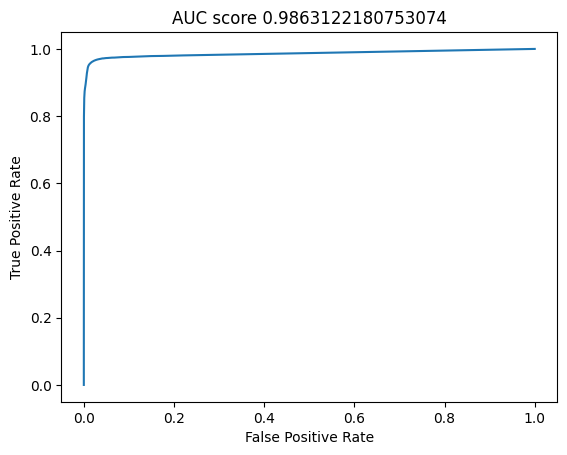

In [3]:
#time the script running time
start_time = time.time()

#file that includes reference
filename = r"YourPath"
#read as dask (faster) and convert to geopandas for processing
ddf = dask_gpd.read_parquet(filename, npartitions=2)
df = ddf.compute()
df = df.dropna(subset=['ref_class']) #if some error in joining of ref_class


#Calculate the percentage of null values per column and drop the ones that contain over 99% nulls
filter = (df.isnull().mean() * 100)>99
drop_me = filter[filter].index.to_list()
df = df.drop(columns=drop_me)
len(df)

#define classes that you want to predict, e.g. here overlap with area that is classified correctly by experts
#Y = df['ref_class']

#Columns to use in the equation, 1 oja, 3 puro -> the higher the more likely natural
Pos_columns = ['length','length_simplified', 'length_ratio','num_vertices','sinuosity','Neighbor_DistanceSum','Neighbor_DistanceMean',
                'DTW1ha_mean', 'DTW1ha_median','slope_mean','slope_median','soil_surface','soil_base']
Neg_columns = ['max_distance','mean_distance']
Maybe_columns = ['DTW1ha','slope','soil']
Other_columns = ['mtk_id', 'sijaintitarkkuus', 'korkeustarkkuus', 'aineistolahde',
       'alkupvm', 'kulkutapa', 'kohderyhma', 'kohdeluokka',
       'aluejakoonosallistuminen', 'tasosijainti', 'virtausnuoletviittaus',
       'kuntanimi', 'elylyhenne', 'elyylyhenne','LT_Luokka', 'geometry' ]
Added_columns = ['min_distance_seq', 'max_distance_seq','mean_distance_seq', 'stdev_distance_seq']
All_columns = Pos_columns + Neg_columns + Added_columns
#All_columns = [col + '_left' for col in All_columns] #if join added additional suffixes etc
print(f"number of variables used in the equation is: {len(All_columns)}")

def normalize_column(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(x - min_val) / (max_val - min_val) for x in column]
    return normalized_column
    

X = df[All_columns]
normalized_x = []
for column in X:
    #variable names
    name = column + '_norm'
    name2 = column + '_imputed'
    name3 = column + '_z'
    #print(name)
    normalized_x.append(name)

    #missing data filling. nulls are already filled with zeroes on line 42, so here no impact, comment it out for this to take effect
    imputer = SimpleImputer(strategy='median')  # or 'mean', median', 'most_frequent', 'constant'.
    df[name2] = imputer.fit_transform(df[[column]])

    #outlier detection with z-score and their removal
    df[name3] = stats.zscore(df[name2])
    outlier_threshold = 3
    outliers = (df[name3] > outlier_threshold) 
    df[name2] = np.where(outliers, df[name2].max(), df[name2]) #if outlier, replace with max value
    outliers2 = (df[name3] < -outlier_threshold)
    df[name2] = np.where(outliers2, df[name2].min(), df[name2]) #if outlier, replace with min value

    #normalization function
    df[name] = normalize_column(df[name2])

print(f"columns used and normalized: {normalized_x}")


#define target variable Y or dependent variable as x is independent -> y = x1 + x2 -x3 equation
Y = df['ref_class']
#define independent variables
X = df[normalized_x]
#split data into train and test sections
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15) #normally use a larger test set, here too good results, so set to 15%
classifier = RandomForestClassifier(n_estimators=100,criterion='gini', random_state= 0, n_jobs=-1) #gini, entropy
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
#REMEMBER TO SELECT THE RIGHT CLASS
y_pred_perc = classifier.predict_proba(X_test)[:,1] #[:,0]is probability of class 0, [:,1] of class 1
print(classification_report(y_test,y_pred))

# ROC curve
fpr, tpr, thresholds  = metrics.roc_curve(y_test, y_pred_perc)
plt.figure()
plt.title(f"AUC score {metrics.roc_auc_score(y_test, y_pred_perc)}")
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig(r"YourPath.png")
#plt.show()

#Utilization of Random forest model
print ("model trained, starting Random forest classification")
filename = r"YourPath"

ddf = dask_gpd.read_parquet(filename, npartitions=1)
df = ddf.compute()

def normalize_column(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(x - min_val) / (max_val - min_val) for x in column]
    return normalized_column

#These two lines are optional, comment out if reason of error    
All_columns_left = [col + '_left' for col in All_columns] #if join added additional suffixes etc
df = df.rename(columns=dict(zip(All_columns_left,All_columns))) #rename to utilize model with original/other input names

X = df[All_columns]
normalized_x = []
for column in X:
    #variable names
    name = column + '_norm'
    name2 = column + '_imputed'
    name3 = column + '_z'
    #print(name)
    normalized_x.append(name)

    #missing data filling. nulls are already filled with zeroes on line 42, so here no impact, comment it out for this to take effect
    imputer = SimpleImputer(strategy='median')  # or 'mean', median', 'most_frequent', 'constant'.
    df[name2] = imputer.fit_transform(df[[column]])

    #outlier detection with z-score and their removal
    df[name3] = stats.zscore(df[name2])
    outlier_threshold = 3
    outliers = (df[name3] > outlier_threshold) 
    df[name2] = np.where(outliers, df[name2].max(), df[name2]) #if outlier, replace with max value
    outliers2 = (df[name3] < -outlier_threshold)
    df[name2] = np.where(outliers2, df[name2].min(), df[name2]) #if outlier, replace with min value

    #normalization function
    df[name] = normalize_column(df[name2])
    #df[name] = normalize_column(df[column])

print(f"columns used and normalized: {normalized_x}")

X = df[normalized_x]
#df['predicted_class'] = classifier.predict(X)
df['StreamProbRF'] = classifier.predict_proba(X)[:,1] #0 for class 0, 1 for 1


# Neural Network
print ("model trained, starting Neural Network classification")

#first parameter is number of units or neurons
#each line of layers.dense is a "hidden layer" of neurons. e.g. here the the NN is 64-32-1 layered network
#The activation function introduces non-linearity to the model, allowing it to learn complex patterns in the data. 
#Without a non-linear activation function, the model would behave like a linear regression model, regardless of the number of layers
model = keras.Sequential([
    #keras.layers.Dense(64, activation='relu', input_dim=len(X_train.columns)),
    keras.layers.Dense(64, activation='relu', input_dim=len(All_columns)),
    keras.layers.Dense(32, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])


#Binary Crossentropy: Use case: Binary classification tasks with sigmoid activation in the output layer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

#batch_size.  It defines the number of samples that will be processed by the model at each iteration during training. 
# In other words, instead of updating the model's weights after processing the entire dataset (as in batch gradient descent), 
# the weights are updated after processing a small batch of data.
#A smaller batch size can be more noisy but might allow for better generalization, especially with limited data. On the other hand, 
# a larger batch size may provide a smoother training process but could require more memory and may not generalize as well.
model.fit(X_train, y_train, epochs=10, batch_size=64) #if overfitting is a problem, low epoch recommended

#test accuracy with test data
print("test data results")
test_loss, test_accuracy = model.evaluate(X_test, y_test)

df['StreamProbNN'] = model.predict(X)

#saving and dropping
cols_to_drop = [col for col in df.columns if col.endswith('_norm') or col.endswith('_z') or col.endswith('_imputed') or col.endswith('_right')]
df = df.drop(cols_to_drop, axis=1)

# assume that the correct classification is something in between different model predictions and assume its the mean
NumberOfModelPredictions = 2
selected_columns = df.iloc[:, -NumberOfModelPredictions:]
df['predicted_class_mean'] = selected_columns.mean(axis=1)
print(df.predicted_class.describe())

end_time = time.time()
execution_time = end_time - start_time
execution_time_minutes = execution_time / 60
print("Total time used: {:.2f} minutes".format(execution_time_minutes))

df['unique_id'] = ['id_' + str(i) for i in range(1, len(df) + 1)]

out_file = r"YourPath"
df.to_parquet(out_file)
print(len(df))
#print(f"saving to {out_file}")

# Add data from other yearly versions
to cover more area, eg. restoration of swamps that can lead to filled streams and removed lines. In this classification once ditched, is always ditched

-for this additional data, only "Creation of classification context" and "Apply machine learning methods" are run, with the assumption that as only additional data,
there is no need to dissolve (disjoint parts are short) and that it is not necessary to split it in smaller processing parts

-in purely spatial processes, QGIS (or maybe PostGis) can sometimes be faster and less error prone. it seemed to be the case here, thus this part was actually done in QGIS, the python code is presented just as reference as how it might be done. QGIS python code is the following:

processing.run("native:selectbylocation", {'INPUT':'path/MTK-virtavesi_2009.gpkg|layername=virtavesikapea','PREDICATE':[2],'INTERSECT':'path/MTK-virtavesi_2024.gpkg|layername=virtavesikapea','METHOD':0})
where predicate[2] is disjoint, method 0 is creating new selection -> export selected

In [2]:
#this part has never been run until the end (computationally expensive and RAM heavy), instead QGIS select by location, disjoint was used

import dask_geopandas as dask_gpd

filename1 = r"YourPath"
filename2 = r"YourPath"
filename3 = r"YourPath"

layer2 = 'virtavesikapea'
layer3 = 'virtavesiviivat'

# Assuming gdf1 and gdf2 are your GeoDataFrames
gddf1 = dask_gpd.read_file(filename1, npartitions=4)
gddf2 = dask_gpd.read_file(filename2, layer=layer2, npartitions=4)

gdf1 = gddf1.compute()
print("gdf1 done")
gdf2 = gddf2.compute()
print("gdf2 done")


# Find the non-overlapping areas in gdf2
non_intersecting = gdf2.disjoint(gdf1.unary_union)

len(non_intersecting)

gdf1 done
gdf2 done


# Asses variable significance
All variables are not necessary significant in classification and can cause missclassification

-shapley values tell about variable significance, the first mentioned is the most vital for the model  
-beware. computationally heavy and needs the classifier block to be run first
eg. classifier = RandomForestClassifier(n_estimators=20,criterion='gini', random_state= 0, n_jobs=-1)  
-these results can be used to optimize the model via variable selection

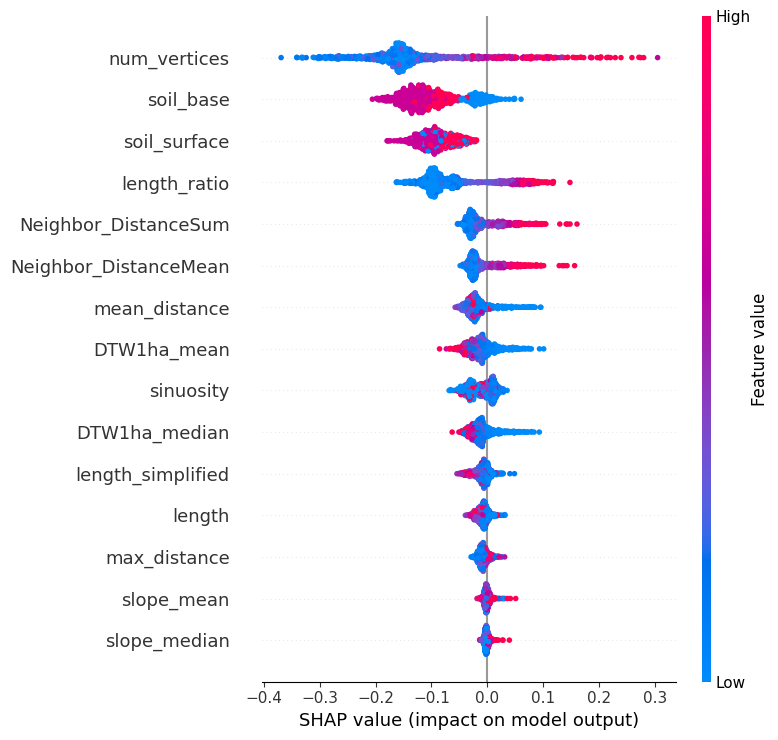

In [ ]:
#smaller sample for test uses
#keep in mind that if the Y=1 is only minority, subset might include only one or less such cases and draw conclusions
#sampling techniques should be considered. using all is computationally expensive if 1000 takes 5min on i9 cpu, 4000 took 153m
X1000 = shap.utils.sample(X, 1000)  # 1000 instances for use as the background distribution

explainer = shap.Explainer(classifier) #need to run the model first to have the variable defined!
shap_values = explainer(sample[All_columns])

#3D array with 1000 instances, 8 features, and 2 classes. (1000,8,2)
np.shape(shap_values.values)


class_idx = 1  # index of the class you're interested in, here it is OGF = 1
shap.summary_plot(shap_values[:, :, class_idx], sample[All_columns])

# Still not good? Consider following

## add more training data

In [ ]:
file1 = r"YourPath"
#file2 is basically pseudo reference data, where the model uses a filtered dataset as input, instead of manually classified. only use if necessary
#adds human error and bias to the model as all "vertices=2,sinuosity=1,NeighborDistMean<75" are not in fact ditches
file2 = r"YourPath\Ojat_Vertice2_sinuosity1_Neighbor_DistanceMean75.parquet"

gdf1 = gpd.read_parquet(file1)
gdf2 = gpd.read_parquet(file2)
gdf2['ref_class'] = 0 #added are assumed to be ditches

#common_columns = set(gdf1.columns).intersection(gdf2.columns)
#common_columns_list = list(common_columns)

#parameters used in the models + ref_class + geometry
Pos_columns = ['length','length_simplified', 'length_ratio','num_vertices','sinuosity','Neighbor_DistanceSum','Neighbor_DistanceMean',
                'DTW1ha_mean', 'DTW1ha_median','slope_mean','slope_median','soil_surface','soil_base']
Neg_columns = ['max_distance','mean_distance'] 
MustInclude = ['ref_class', 'geometry']
All_columns = Pos_columns + Neg_columns + MustInclude


combined = pd.concat([gdf1[All_columns], gdf2[All_columns]], ignore_index=True)
combined.to_parquet(r"YourPath")
len(combined)

In [3]:
import dask_geopandas as dask_gpd

filename = r'YourPath\Reference_All.parquet'
ddf = dask_gpd.read_parquet(filename, npartitions=1)
ddf.ref_class.value_counts().compute()

0.0    3088584
1.0     348231
Name: ref_class, dtype: int64

## add more variables
Remember to add the additional variables to both training data and main data

In [2]:
#for reference
import math
import statistics

filename = r"YourPath"
ddf = dask_gpd.read_parquet(filename, npartitions=12)
df = ddf.compute()

def calculate_distance(point1, point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def calculate_sequential_distances(line):
    vertices = list(line.coords)
    distances = []
    for i in range(len(vertices) - 1):
        distances.append(calculate_distance(vertices[i], vertices[i+1]))
    return distances

def calculate_stats_sequential_distance(line):
    distances = calculate_sequential_distances(line)
    min_distance = round(min(distances), 2)
    #med_distance = round(statistics.median(distances), 2)
    max_distance = round(max(distances), 2)
    mean_distance = round(sum(distances) / len(distances), 2)
    #variance_distance = round(statistics.variance(distances), 2) if len(distances) > 1 else 0
    stdev_distance = round(statistics.stdev(distances), 2) if len(distances) > 1 else 0
    return min_distance, max_distance, mean_distance, stdev_distance #med_distance, variance_distance,

df['min_distance_seq'], df['max_distance_seq'], df['mean_distance_seq'], df['stdev_distance_seq'] = zip(*df['geometry'].apply(calculate_stats_sequential_distance))

print(len(df))
outfile = r"YourPath"
df.to_parquet(outfile)

3437559


In [2]:
#for main data
import math
import statistics

filename = r"YourPath"
ddf = dask_gpd.read_parquet(filename, npartitions=12)
df = ddf.compute()

def calculate_distance(point1, point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def calculate_sequential_distances(line):
    vertices = list(line.coords)
    distances = []
    for i in range(len(vertices) - 1):
        distances.append(calculate_distance(vertices[i], vertices[i+1]))
    return distances

def calculate_stats_sequential_distance(line):
    distances = calculate_sequential_distances(line)
    min_distance = round(min(distances), 2)
    #med_distance = round(statistics.median(distances), 2)
    max_distance = round(max(distances), 2)
    mean_distance = round(sum(distances) / len(distances), 2)
    #variance_distance = round(statistics.variance(distances), 2) if len(distances) > 1 else 0
    stdev_distance = round(statistics.stdev(distances), 2) if len(distances) > 1 else 0
    return min_distance, max_distance, mean_distance, stdev_distance #med_distance, variance_distance,

df['min_distance_seq'], df['max_distance_seq'], df['mean_distance_seq'], df['stdev_distance_seq'] = zip(*df['geometry'].apply(calculate_stats_sequential_distance))

outfile = r"YourPath"
df.to_parquet(outfile)

# Optional

## Divide into 3 classes
-stream, possibly stream, ditch
-if one wants a more streamlined categorized inspection instead of a continuous probabilistic one
-adds subjective interpretation and bias

In [4]:
filename = r"YourPath"
ddf = dask_gpd.read_parquet(filename, npartitions=12)

# Your classified data
ditch = ddf[ddf['predicted_class'] < 0.6]
possible_stream = ddf[(ddf['predicted_class'] > 0.6) & (ddf['predicted_class'] <= 0.85)]
stream = ddf[ddf['predicted_class'] > 0.85]

#df = stream.compute()

## Rasterize

The dataset can be quite heavy to run and rasterization can speed up further things. Assuming ditch impact range is about 50 meters, this is used as the cell size. 

The dataset was first split into ditch and stream like features with threshold value 0.5 predicted_class. In this combined raster, ditch like features are emphasized. If both rasters have data (not equal to 0), “ditch_50m@1” raster values are used. 

If both rasters have data (not equal to 0), “ditch_50m@1” raster values are used.
If only the “stream_50m@1” raster has data, “stream_50m@1” raster values are used.
If only the “ditch_50m@1” raster has data, “ditch_50m@1” raster values are used.

Original rasterization in QGIS
processing.run("gdal:rasterize", {'INPUT':'Path/ditch.parquet|layername=ditch','FIELD':'predicted_class_mean','BURN':0,'USE_Z':False,'UNITS':1,'WIDTH':50,'HEIGHT':50,'EXTENT':'75417.607000000,732854.508000000,6636746.414000000,7776752.929000000 [EPSG:3067]','NODATA':0,'OPTIONS':'','DATA_TYPE':5,'INIT':None,'INVERT':False,'EXTRA':'','OUTPUT':Path/ditch_50m.tif'})
+the same process for stream

In [5]:
import rasterio
import numpy as np


# Open the raster files
ditch = rasterio.open(r'Path\ditch_50m.tif')
stream = rasterio.open(r'Path\stream_50m.tif')

ditch_data = ditch.read(1)
stream_data = stream.read(1)

# Create a new array to hold the result
result = np.zeros(ditch_data.shape, dtype=ditch_data.dtype)

# Apply the conditions
result[(ditch_data != 0) & (stream_data != 0)] = ditch_data[(ditch_data != 0) & (stream_data != 0)]
result[(ditch_data == 0) & (stream_data != 0)] = stream_data[(ditch_data == 0) & (stream_data != 0)]
result[(ditch_data != 0) & (stream_data == 0)] = ditch_data[(ditch_data != 0) & (stream_data == 0)]

# Save the result to a new raster file
with rasterio.open(r'Path\combined_50m.tif', 'w', **ditch.profile) as dst:
    dst.write(result, 1)

# Close the datasets
ditch.close()
stream.close()